In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
###### change current path
import os
path = "/content/gdrive/MyDrive/NUS_IRS_Project/"
os.chdir(path)

In [3]:
!ls

data  data_gathering  matching	Modelling  models  webapp_model.zip


In [4]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline

import re
import datetime
from datetime import date
from time import strptime
import operator

import nltk
from wordcloud import WordCloud

nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Theme Configuration  
choosing color template for graph and word cloud

In [5]:
# for other theme, please run: mpl.pyplot.style.available
PLOT_PALETTE = 'tableau-colorblind10'
# for other color map, please run: mpl.pyplot.colormaps()
WORDCLOUD_COLOR_MAP = 'tab10_r'

In [6]:
# set palette color
plt.style.use(PLOT_PALETTE)

read resume dataset

In [7]:
#df = pd.read_csv('../input/resume-dataset/Resume/Resume.csv')
df = pd.read_csv('data/dataset_resume_new.csv')
df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [8]:
df = df[['ID','Resume_str','Category']]
df.head()

,ID,Resume_str,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,33176873,HR DIRECTOR Summary Over 2...,HR
3,27018550,HR SPECIALIST Summary Dedica...,HR
4,17812897,HR MANAGER Skill Highlights ...,HR


In [10]:
categories = np.sort(df['Category'].unique())
categories

array(['ACCOUNTANT', 'ADVOCATE', 'AGRICULTURE', 'APPAREL', 'ARTS',
       'AUTOMOBILE', 'AVIATION', 'BANKING', 'BPO', 'BUSINESS-DEVELOPMENT',
       'CHEF', 'CONSTRUCTION', 'CONSULTANT', 'DESIGNER', 'DIGITAL-MEDIA',
       'ENGINEERING', 'FINANCE', 'FITNESS', 'HEALTHCARE', 'HR',
       'INFORMATION-TECHNOLOGY', 'PUBLIC-RELATIONS', 'SALES', 'TEACHER'],
      dtype=object)

In [12]:
# create new df for corpus and category
df_categories = [df[df['Category'] == category].loc[:, ['Resume_str', 'Category']] for category in categories]
df_categories[10]

,Resume_str,Category
1357,CHEF Career Focus I am a nu...,CHEF
1358,CHEF Summary Customer-o...,CHEF
1359,CHEF Career Overview De...,CHEF
1360,CHEF Summary Experienced ca...,CHEF
1361,RM Roxanne Mejia Summary ...,CHEF
...,...,...
1470,OWNER/CHEF Summary Chef wit...,CHEF
1471,KINDERGARTEN TEACHER Professi...,CHEF
1472,SUBSTITUTE PARA PROFESSIONAL Su...,CHEF
1473,EXECUTIVE CHEF-PARTNER Summ...,CHEF


In [13]:
def wordcloud(df):
    txt = ' '.join(txt for txt in df['Resume_str'])
    wordcloud = WordCloud(
        height=2000,
        width=4000,
        colormap=WORDCLOUD_COLOR_MAP
    ).generate(txt)

    return wordcloud

In [14]:
plt.figure(figsize=(32, 28))

for i, category in enumerate(categories):
    wc = wordcloud(df_categories[i])

    plt.subplot(6, 4, i + 1).set_title(category)
    plt.imshow(wc)
    plt.axis('off')
    plt.plot()

plt.show()
plt.close()

Output hidden; open in https://colab.research.google.com to view.

## Add name and file name

In [ ]:
import random

with open('data/NameDataset/names.txt', 'r') as f:
    namesM = f.readlines()
with open('data/NameDataset/namesF.txt', 'r') as f:
    namesF = f.readlines()
with open('data/NameDataset/lastnames.txt', 'r') as f:
    lastnames = f.readlines()

def get_name():
  t = random.randint(0,9)
  if t > 4:
    name = random.choice(namesM) + ' ' + random.choice(lastnames)
  else:
    name = random.choice(namesF) + ' ' + random.choice(lastnames)
  
  name = name.replace('\n', '')

  return name

In [ ]:
df['name'] = ' '
df['file_name'] = ' '

In [ ]:
df['name'] = df.apply(lambda x: get_name(), axis=1)

In [ ]:
def get_file_name(x):
  t_list = x.split(' ')
  file_name = "_".join(t_list) + "_resume.pdf"

  return file_name

In [ ]:
df['file_name'] = df.apply(lambda x: get_file_name(x['name']), axis=1)

In [ ]:
df.head()

,ID,Resume_str,Category,name,file_name
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR,Garp Alspach,Garp_Alspach_resume.pdf
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR,Callie Haske,Callie_Haske_resume.pdf
2,33176873,HR DIRECTOR Summary Over 2...,HR,Guenevere Wannamaker,Guenevere_Wannamaker_resume.pdf
3,27018550,HR SPECIALIST Summary Dedica...,HR,Barnie Palms,Barnie_Palms_resume.pdf
4,17812897,HR MANAGER Skill Highlights ...,HR,Prudy Prall,Prudy_Prall_resume.pdf


In [ ]:
df.to_csv('data/EDA_resume.csv', index=False)

## Analyze

In [ ]:
def preprocess(txt, stopwords):
    # convert all characters in the string to lower case
    txt = txt.lower()
    # remove non-english characters, punctuation and numbers
    txt = re.sub('[^a-zA-Z]', ' ', txt)
    txt = re.sub('http\S+\s*', ' ', txt)  # remove URLs
    txt = re.sub('RT|cc', ' ', txt)  # remove RT and cc
    txt = re.sub('#\S+', '', txt)  # remove hashtags
    txt = re.sub('@\S+', '  ', txt)  # remove mentions
    txt = re.sub('\s+', ' ', txt)  # remove extra whitespace
    # tokenize word
    txt = nltk.tokenize.word_tokenize(txt)
    # remove stop words
    txt = [w for w in txt if not w in stopwords]
    
    return ' '.join(txt)

In [ ]:
# preprocessing text
stopwords = nltk.corpus.stopwords.words('english')

In [ ]:
df['Resume_str'] = df['Resume_str'].apply(lambda w: preprocess(w,stopwords))

In [ ]:
df['Resume_str'][0:5]

0    hr administrator marketing associate hr admini...
1    hr specialist us hr operations summary versati...
2    hr director summary years experience recruitin...
3    hr specialist summary dedicated driven dynamic...
4    hr manager skill highlights hr skills hr depar...
Name: Resume_str, dtype: object

In [ ]:
import string
from nltk.corpus import stopwords
oneSetOfStopWords = set(stopwords.words('english')+['``',"''"])
totalWords =[]
Sentences = df['Resume_str'].values
#cleanedSentences = ""
### remove stop words and punctuation
for records in Sentences:
    #cleanedSentences += records
    requiredWords = nltk.word_tokenize(records)
    for word in requiredWords:
        if word not in oneSetOfStopWords and word not in string.punctuation:
            totalWords.append(word)
    
wordfreqdist = nltk.FreqDist(totalWords)
mostcommon = wordfreqdist.most_common(50)
print(mostcommon)

[('state', 16159), ('company', 15212), ('city', 15077), ('management', 12174), ('name', 11739), ('sales', 8275), ('customer', 7927), ('business', 7866), ('skills', 7729), ('new', 6409), ('service', 6223), ('team', 6073), ('development', 5731), ('training', 5637), ('experience', 5632), ('project', 5362), ('work', 4817), ('manager', 4534), ('information', 4502), ('marketing', 4489), ('financial', 4227), ('office', 4189), ('support', 4123), ('education', 4093), ('including', 4045), ('staff', 3950), ('professional', 3857), ('data', 3797), ('system', 3697), ('systems', 3559), ('university', 3477), ('managed', 3432), ('process', 3428), ('customers', 3418), ('design', 3384), ('quality', 3367), ('client', 3272), ('clients', 3244), ('developed', 3228), ('reports', 3090), ('analysis', 3052), ('operations', 3008), ('product', 2951), ('high', 2950), ('program', 2934), ('services', 2847), ('ounting', 2843), ('microsoft', 2830), ('current', 2787), ('ounts', 2782)]


In [ ]:
mostcommon_t = wordfreqdist.most_common(20)
print(mostcommon_t)

[('state', 16159), ('company', 15212), ('city', 15077), ('management', 12174), ('name', 11739), ('sales', 8275), ('customer', 7927), ('business', 7866), ('skills', 7729), ('new', 6409), ('service', 6223), ('team', 6073), ('development', 5731), ('training', 5637), ('experience', 5632), ('project', 5362), ('work', 4817), ('manager', 4534), ('information', 4502), ('marketing', 4489)]


In [ ]:
for word, num in mostcommon_t:
  oneSetOfStopWords.add(word)

In [ ]:
cleanedSentences = ""
totalWords =[]
### remove stop words
for records in Sentences:
    cleanedSentences += records
    requiredWords = nltk.word_tokenize(records)
    for word in requiredWords:
        if word not in oneSetOfStopWords:
            totalWords.append(word)

In [ ]:
wordfreqdist = nltk.FreqDist(totalWords)
mostcommon = wordfreqdist.most_common(20)
print(mostcommon)

[('financial', 4227), ('office', 4189), ('support', 4123), ('education', 4093), ('including', 4045), ('staff', 3950), ('professional', 3857), ('data', 3797), ('system', 3697), ('systems', 3559), ('university', 3477), ('managed', 3432), ('process', 3428), ('customers', 3418), ('design', 3384), ('quality', 3367), ('client', 3272), ('clients', 3244), ('developed', 3228), ('reports', 3090)]


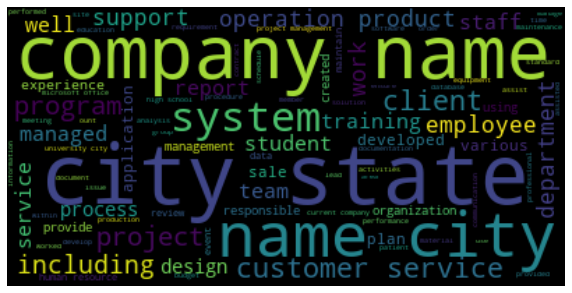

In [ ]:
wc = WordCloud().generate(cleanedSentences)
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
resume = pd.read_csv('data/vector_resume_20.csv')

In [ ]:
resume.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          2483 non-null   float64
 1   Resume_str  2483 non-null   object 
 2   Category    2483 non-null   object 
 3   name        2483 non-null   object 
 4   file_name   2483 non-null   object 
 5   vec_1       2483 non-null   float64
 6   vec_2       2483 non-null   float64
 7   vec_3       2483 non-null   float64
 8   vec_4       2483 non-null   float64
 9   vec_5       2483 non-null   float64
 10  vec_6       2483 non-null   float64
 11  vec_7       2483 non-null   float64
 12  vec_8       2483 non-null   float64
 13  vec_9       2483 non-null   float64
 14  vec_10      2483 non-null   float64
 15  vec_11      2483 non-null   float64
 16  vec_12      2483 non-null   float64
 17  vec_13      2483 non-null   float64
 18  vec_14      2483 non-null   float64
 19  vec_15      2483 non-null  

In [ ]:
resume['Resume_str'].isnull().sum()

1

In [ ]:
resume.drop(resume[resume['Resume_str'].isnull()].index, axis=0, inplace=True)

In [ ]:
resume['Resume_str'].isnull().sum()

0

In [ ]:
resume.to_csv('data/vector_resume_20_new.csv', index=False)